In [1]:
import numpy as np
import pandas as pd

PARTICIPANT_ID='Sub01'

df_csv=pd.read_csv('data/Provo_Corpus-Eyetracking_Data(sub1-10).csv',usecols=['Participant_ID','Text_ID','Word_Cleaned','IA_SKIP'])
df_csv=df_csv[(df_csv['Participant_ID']==PARTICIPANT_ID)]
df_csv=df_csv.drop(['Participant_ID'],axis=1) #删除列，轴为1
df_csv=df_csv.fillna(' ')
list_data=[]
for j in range(1,56): #句子1-55
    df=df_csv[(df_csv['Text_ID']==j)][['Word_Cleaned','IA_SKIP']] #只保留'Word_Cleaned','IA_SKIP'两列
    mylist = np.array(df).tolist()
    list_data.append(mylist)

texts=[[j[0] for j in i]for i in list_data]
labels=[[j[1] for j in i]for i in list_data]
#print(labels)

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_NB_WORDS = 2000 #字典大小
MAX_SEQUENCE_LENGTH = max(len(s) for s in texts)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
MAX_NB_WORDS = len(word_index)+1 #重新修正字典大小
#print(word_index)
x = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)  # left padding
print(x)
print(x.shape)
y = pad_sequences(labels, MAX_SEQUENCE_LENGTH, value=-1)  # left padding
y = np.expand_dims(y, 2) 
#这是因为crf层期望标签具有不同的形状。
#通常，我们的标签的shape为(num_samples,max_length)，但crf层需要的shape为(num_samples,max_length,1)。
#解决方法：将标签扩一维
#https://blog.csdn.net/qq_31456593/article/details/89578018

#用Dense做激活层的时候，仍然需要这个expand_dims。

print(y)
print(y.shape)
train_x=x[0:45]
train_y=y[0:45]
test_x=x[45:]
test_y=y[45:]

Using TensorFlow backend.


[[   0    0    0 ...    3  340    6]
 [   0  160  161 ...   15  363    6]
 [   0    0  364 ...  377  378    6]
 ...
 [   0    0    0 ...   32   54    6]
 [   0    0    0 ... 1172  120    6]
 [ 184 1173 1174 ... 1192    6    6]]
(55, 60)
[[[-1]
  [-1]
  [-1]
  ...
  [ 1]
  [ 0]
  [ 0]]

 [[-1]
  [ 0]
  [ 0]
  ...
  [ 1]
  [ 0]
  [ 0]]

 [[-1]
  [-1]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 ...

 [[-1]
  [-1]
  [-1]
  ...
  [ 1]
  [ 0]
  [ 0]]

 [[-1]
  [-1]
  [-1]
  ...
  [ 0]
  [ 1]
  [ 0]]

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 0]
  [ 1]
  [ 0]]]
(55, 60, 1)


In [3]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM,Dense, Conv1D, MaxPooling1D,TimeDistributed
from keras_contrib.layers import CRF

EMBEDDING_DIM = 200
BiRNN_UNITS = 200

model = Sequential()
#model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, mask_zero=True,input_shape=(MAX_SEQUENCE_LENGTH,)))  # Random embedding
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_shape=(MAX_SEQUENCE_LENGTH,)))  # Random embedding
#model.add(Conv1D(32, 7, activation='relu'))
#model.add((MaxPooling1D(5)))
model.add(Bidirectional(LSTM(BiRNN_UNITS // 2, return_sequences=True)))
model.add(Dense(1,activation='sigmoid'))
#crf = CRF(2, sparse_target=True)
#model.add(crf)
model.summary()
#model.compile(optimizer='adam', loss=crf.loss_function, metrics=[crf.accuracy])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 200)           238600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
dense_1 (Dense)              (None, 60, 1)             201       
Total params: 479,601
Trainable params: 479,601
Non-trainable params: 0
_________________________________________________________________


In [4]:
EPOCHS = 10

# train model
train_history=model.fit(train_x, train_y,batch_size=4,epochs=EPOCHS, validation_data=[test_x, test_y])
model.save('model/crf.h5')

Instructions for updating:
Use tf.cast instead.
Train on 45 samples, validate on 10 samples
Epoch 1/10
45/45 [==============================] - 3s 73ms/step - loss: -0.2055 - acc: 0.5385 - val_loss: 0.4227 - val_acc: 0.5150
Epoch 2/10
45/45 [==============================] - 1s 23ms/step - loss: -1.5681 - acc: 0.5019 - val_loss: -0.6552 - val_acc: 0.4900
Epoch 3/10
45/45 [==============================] - 1s 23ms/step - loss: -2.0342 - acc: 0.5219 - val_loss: -0.7662 - val_acc: 0.5050
Epoch 4/10
45/45 [==============================] - 1s 23ms/step - loss: -2.2096 - acc: 0.5500 - val_loss: -0.9672 - val_acc: 0.5183
Epoch 5/10
45/45 [==============================] - 1s 23ms/step - loss: -2.3123 - acc: 0.5604 - val_loss: -1.1174 - val_acc: 0.5233
Epoch 6/10
45/45 [==============================] - 1s 22ms/step - loss: -2.3725 - acc: 0.5733 - val_loss: -1.1869 - val_acc: 0.5117
Epoch 7/10
45/45 [==============================] - 1s 23ms/step - loss: -2.4161 - acc: 0.5789 - val_loss: -1.1

In [5]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'])
    plt.show()


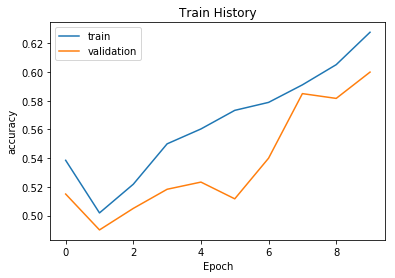

In [6]:
show_train_history(train_history,'acc','val_acc')